In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import seaborn as sns
import matplotlib.patches as mpatches
import warnings

In [2]:
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from subprocess import call
from IPython.display import Image

In [3]:
from platform import python_version
print(python_version())

3.8.6


In [4]:
# RobustScaler is less prone to outliers.

df = pd.read_csv('../creditcard.csv')
std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

amount = df['scaled_amount']
time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'amount', amount)
df.insert(1, 'time', time)
df.head()

amount      time        V1        V2        V3        V4        V5  \
0  1.783274 -0.994983 -1.359807 -0.072781  2.536347  1.378155 -0.338321   
1 -0.269825 -0.994983  1.191857  0.266151  0.166480  0.448154  0.060018   
2  4.983721 -0.994972 -1.358354 -1.340163  1.773209  0.379780 -0.503198   
3  1.418291 -0.994972 -0.966272 -0.185226  1.792993 -0.863291 -0.010309   
4  0.670579 -0.994960 -1.158233  0.877737  1.548718  0.403034 -0.407193   

         V6        V7        V8  ...       V20       V21       V22       V23  \
0  0.462388  0.239599  0.098698  ...  0.251412 -0.018307  0.277838 -0.110474   
1 -0.082361 -0.078803  0.085102  ... -0.069083 -0.225775 -0.638672  0.101288   
2  1.800499  0.791461  0.247676  ...  0.524980  0.247998  0.771679  0.909412   
3  1.247203  0.237609  0.377436  ... -0.208038 -0.108300  0.005274 -0.190321   
4  0.095921  0.592941 -0.270533  ...  0.408542 -0.009431  0.798278 -0.137458   

        V24       V25       V26       V27       V28  Class  
0  0.066928  0.128539 -0.189115  0.133558 -0.021053      0  
1 -0.339846  0.167170  0.125895 -0.008983  0.014724      0  
2 -0.689281 -0.327642 -0.139097 -0.055353 -0.059752      0  
3 -1.175575  0.647376 -0.221929  0.062723  0.061458      0  
4  0.141267 -0.206010  0.502292  0.219422  0.215153      0  

[5 rows x 31 columns]

In [5]:
df = df.sample(frac=1)

fraud_data = df.loc[df['Class']==1]
nfraud_data = df.loc[df['Class']==0][:492]

normal_distributed_df = pd.concat([fraud_data, nfraud_data])

# Shuffle dataframe rows
ndata = normal_distributed_df.sample(frac=1, random_state=42)

ndata.head()

amount      time        V1        V2        V3        V4        V5  \
154244 -0.098512  0.190768 -2.829233  2.664646  0.666605 -0.227562 -0.638406   
76929  -0.293440 -0.327612  0.016828  2.400826 -4.220360  3.462217 -0.624142   
138459 -0.282401 -0.023896  1.355353  0.363881 -0.266949  0.358329  0.368334   
143188 -0.279466  0.005745 -3.003459  2.096150 -0.487030  3.069453 -1.774329   
79525  -0.293440 -0.312880 -2.630598  5.125759 -6.092255  5.527393  1.605145   

              V6        V7        V8  ...       V20       V21       V22  \
154244  2.169417 -3.306719 -8.503605  ... -1.832393  8.369422 -2.465031   
76929  -1.294303 -2.986028  0.751883  ...  0.590418  0.285832 -0.771508   
138459 -0.256552  0.100756 -0.150904  ...  0.006057 -0.372217 -1.034785   
143188  0.251804 -4.328776 -2.425478  ...  0.692537  0.163967  1.245648   
79525  -2.319884 -3.207076 -1.482583  ...  0.948864 -0.527474  0.220546   

             V23       V24       V25       V26       V27       V28  Class  
154244  1.246919  0.454173 -0.938150  0.574445  0.620240  0.278833      0  
76929  -0.265200 -0.873077  0.939776 -0.219085  0.874494  0.470434      1  
138459 -0.051481 -1.039301  0.424822  0.179066 -0.020681  0.018014      0  
143188 -0.269241  0.537102 -0.220757 -0.059555  0.460710 -0.033551      1  
79525  -1.371110 -0.504899  0.382307  0.395528  0.782036  0.628528      1  

[5 rows x 31 columns]

In [6]:
#Looking at the correlation to create a boxplot
corr = ndata.corr()
corr1 = corr[['Class']]
corr1

Class
amount  0.056605
time   -0.122469
V1     -0.422814
V2      0.483430
V3     -0.568810
V4      0.702882
V5     -0.370696
V6     -0.402620
V7     -0.478759
V8      0.053906
V9     -0.560986
V10    -0.624528
V11     0.682880
V12    -0.683500
V13    -0.019467
V14    -0.752717
V15    -0.040979
V16    -0.590144
V17    -0.562742
V18    -0.464802
V19     0.263941
V20     0.177172
V21     0.125409
V22     0.007748
V23    -0.028027
V24    -0.071803
V25     0.004523
V26     0.026172
V27     0.092757
V28     0.089085
Class   1.000000

In [7]:
#negative correlations smaller than -0.5
corr[corr.Class < -0.5]

amount      time        V1        V2        V3        V4        V5  \
V3  -0.009425  0.137864  0.875582 -0.852180  1.000000 -0.768071  0.852811   
V9   0.013325  0.170050  0.663983 -0.692965  0.770244 -0.791198  0.668939   
V10  0.002440  0.200902  0.741344 -0.763402  0.859639 -0.789125  0.758869   
V12  0.011194  0.251373  0.588797 -0.661888  0.763066 -0.832799  0.619551   
V14  0.043926  0.167772  0.430368 -0.561793  0.656451 -0.794662  0.431291   
V16 -0.007277  0.239420  0.632422 -0.626636  0.725381 -0.717939  0.690131   
V17 -0.009782  0.228474  0.670078 -0.638268  0.739257 -0.710742  0.744937   

           V6        V7        V8  ...       V20       V21       V22  \
V3   0.472629  0.886414 -0.171650  ... -0.360012  0.028333 -0.060690   
V9   0.387129  0.764647 -0.077804  ... -0.395860  0.164062 -0.242721   
V10  0.427355  0.866767 -0.048649  ... -0.385699  0.085379 -0.213939   
V12  0.502988  0.718955 -0.161166  ... -0.228176 -0.076842 -0.106642   
V14  0.540304  0.545734 -0.181416  ... -0.129756 -0.221782  0.063194   
V16  0.436712  0.745319 -0.172635  ... -0.193416 -0.149955 -0.101064   
V17  0.431349  0.770347 -0.217638  ... -0.217631 -0.092789 -0.122270   

          V23       V24       V25       V26       V27       V28     Class  
V3  -0.025842  0.013661 -0.071817  0.000854  0.098783  0.123743 -0.568810  
V9  -0.045025  0.000663 -0.002917 -0.111871  0.121484  0.144200 -0.560986  
V10 -0.044681 -0.011092  0.032156 -0.009133  0.144051  0.142016 -0.624528  
V12  0.016485  0.027872  0.050791 -0.095978 -0.039943  0.003104 -0.683500  
V14  0.025940  0.126092 -0.055737 -0.153698 -0.211550 -0.127418 -0.752717  
V16  0.001927 -0.059123  0.075029 -0.038432 -0.031832  0.002976 -0.590144  
V17  0.021062 -0.096042  0.046750 -0.030845 -0.006491  0.052937 -0.562742  

[7 rows x 31 columns]

In [8]:
#positive correlations greater than 0.5
corr[corr.Class > 0.5]

amount      time        V1        V2        V3        V4        V5  \
V4     0.009952 -0.200416 -0.601005  0.660690 -0.768071  1.000000 -0.574201   
V11   -0.026451 -0.297815 -0.521630  0.611892 -0.713691  0.782193 -0.525610   
Class  0.056605 -0.122469 -0.422814  0.483430 -0.568810  0.702882 -0.370696   

             V6        V7        V8  ...       V20       V21       V22  \
V4    -0.430617 -0.708722  0.102534  ...  0.307767 -0.021498  0.117189   
V11   -0.507185 -0.638444  0.170094  ...  0.203062  0.140297  0.019686   
Class -0.402620 -0.478759  0.053906  ...  0.177172  0.125409  0.007748   

            V23       V24       V25       V26       V27       V28     Class  
V4     0.019925 -0.068605 -0.061096  0.116865 -0.002898 -0.070263  0.702882  
V11   -0.033385 -0.084542  0.006966  0.129547  0.179978  0.041706  0.682880  
Class -0.028027 -0.071803  0.004523  0.026172  0.092757  0.089085  1.000000  

[3 rows x 31 columns]

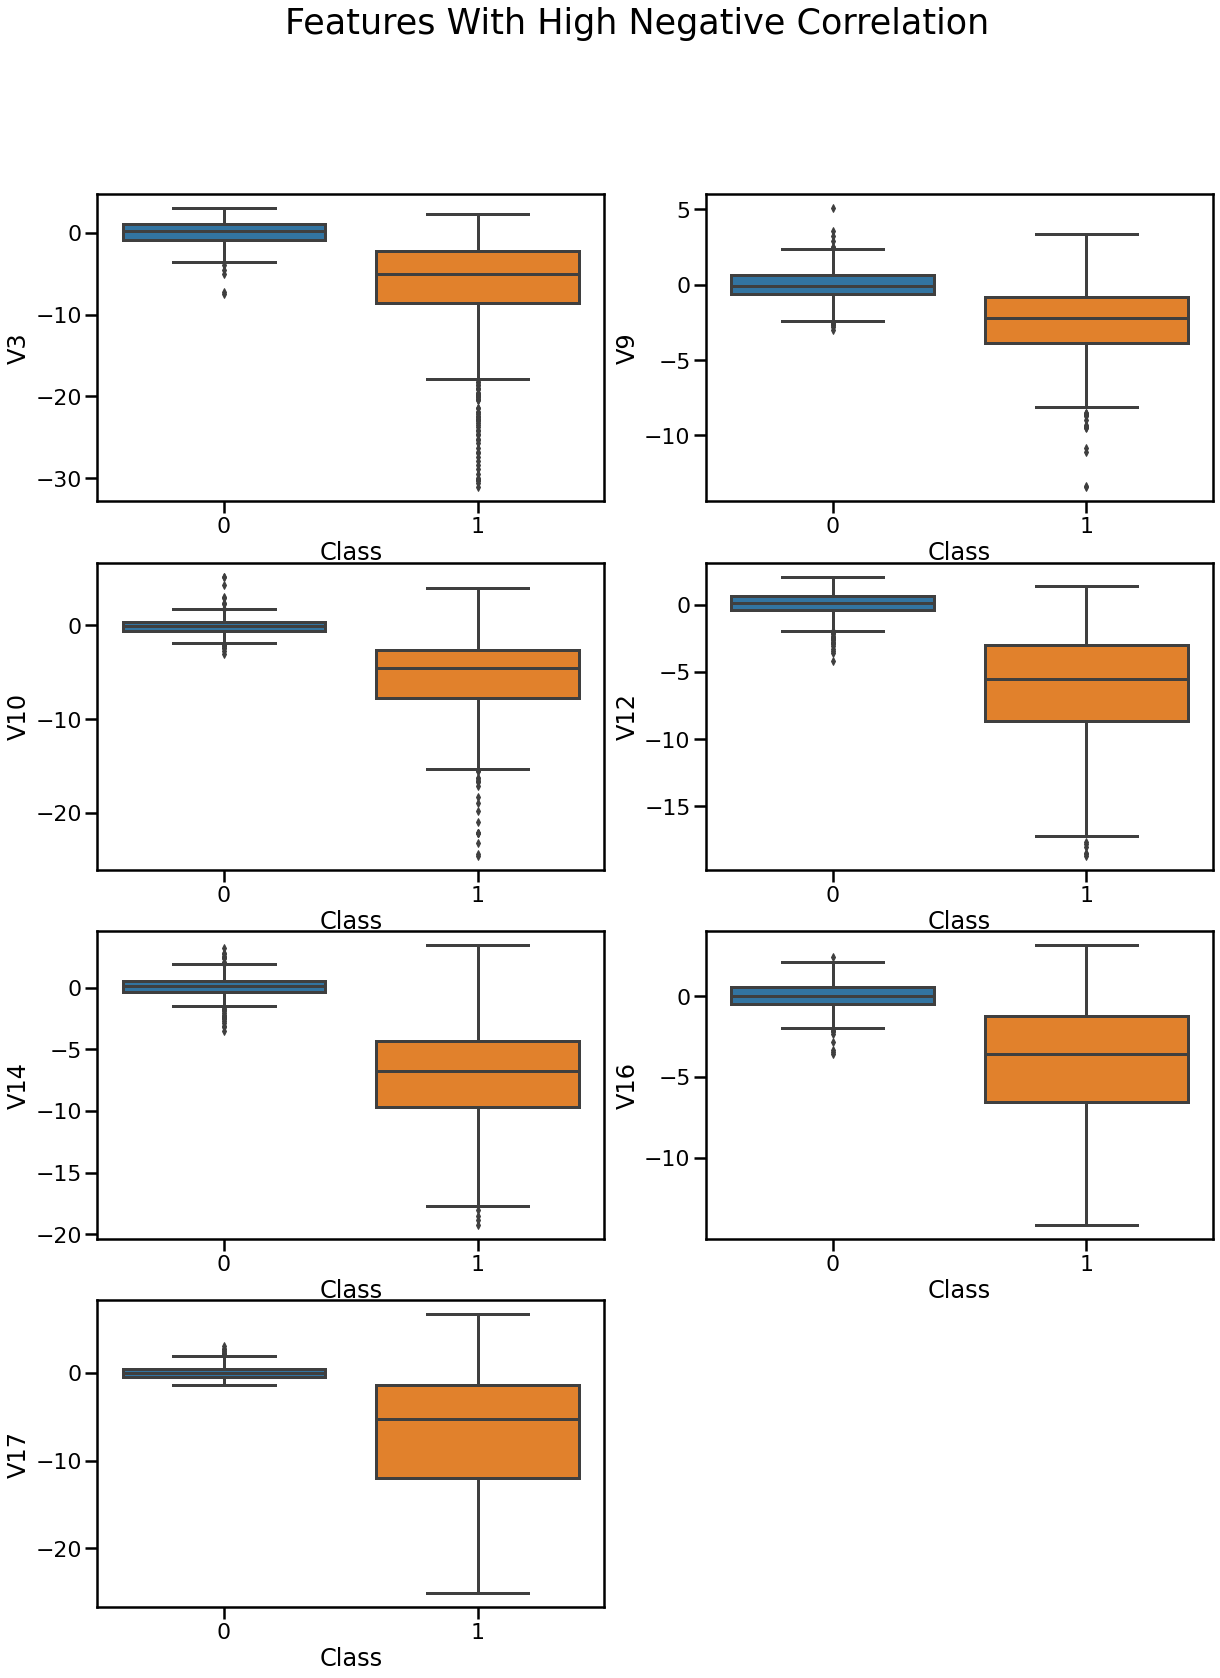

In [15]:
#Visualizing the features w high negative correlation
f, axes = plt.subplots(nrows=4, ncols=2, figsize=(20,26))

f.suptitle('Features With High Negative Correlation', size=35)
sns.boxplot(x="Class", y="V3", data=ndata, ax=axes[0,0])
sns.boxplot(x="Class", y="V9", data=ndata, ax=axes[0,1])

sns.boxplot(x="Class", y="V10", data=ndata, ax=axes[1,0])
sns.boxplot(x="Class", y="V12", data=ndata, ax=axes[1,1])

sns.boxplot(x="Class", y="V14", data=ndata, ax=axes[2,0])
sns.boxplot(x="Class", y="V16", data=ndata, ax=axes[2,1])

sns.boxplot(x="Class", y="V17", data=ndata, ax=axes[3,0])

sns.set_context("poster", font_scale = 1.0, rc={"grid.linewidth": 0.7})
f.delaxes(axes[3,1])

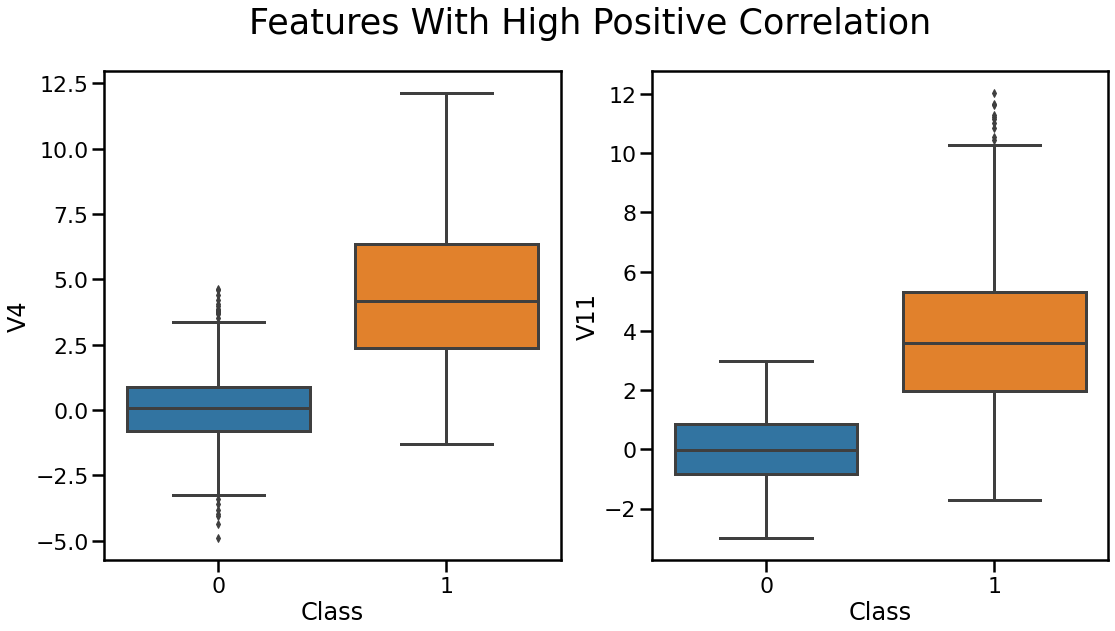

In [10]:
#Visualizing the features w high positive correlation
f, axes = plt.subplots(nrows=1, ncols=2, figsize=(18,9))

f.suptitle('Features With High Positive Correlation', size=35)
sns.boxplot(x="Class", y="V4", data=ndata, ax=axes[0])
sns.boxplot(x="Class", y="V11", data=ndata, ax=axes[1])

sns.set_context("poster", font_scale = 1.0, rc={"grid.linewidth": 0.7})

In [11]:
#Identifying and only removing extreme outliers according to the Interquartile rule
Q1 = ndata.quantile(0.25)
Q3 = ndata.quantile(0.75)
IQR = Q3 - Q1

df2 = ndata[~((ndata < (Q1 - 2.5 * IQR)) |(ndata > (Q3 + 2.5 * IQR))).any(axis=1)]
df2.head()

amount      time        V1        V2        V3        V4        V5  \
76929  -0.293440 -0.327612  0.016828  2.400826 -4.220360  3.462217 -0.624142   
138459 -0.282401 -0.023896  1.355353  0.363881 -0.266949  0.358329  0.368334   
143188 -0.279466  0.005745 -3.003459  2.096150 -0.487030  3.069453 -1.774329   
162911  1.075945  0.361694 -0.801145  0.852692 -1.981399 -1.348057  2.653017   
99919  -0.294977 -0.203891 -0.333320  1.214136  1.705477  0.873158  0.174310   

              V6        V7        V8  ...       V20       V21       V22  \
76929  -1.294303 -2.986028  0.751883  ...  0.590418  0.285832 -0.771508   
138459 -0.256552  0.100756 -0.150904  ...  0.006057 -0.372217 -1.034785   
143188  0.251804 -4.328776 -2.425478  ...  0.692537  0.163967  1.245648   
162911  3.518507  0.353999  1.360885  ...  0.192883  0.117022  0.283968   
99919  -0.639415  0.919206 -0.595229  ...  0.466179 -0.298241 -0.450246   

             V23       V24       V25       V26       V27       V28  Class  
76929  -0.265200 -0.873077  0.939776 -0.219085  0.874494  0.470434      1  
138459 -0.051481 -1.039301  0.424822  0.179066 -0.020681  0.018014      0  
143188 -0.269241  0.537102 -0.220757 -0.059555  0.460710 -0.033551      1  
162911  0.020011  0.616251 -0.090878  0.601814  0.240341  0.201218      0  
99919  -0.095709  0.364500 -0.519034  0.236130 -0.238179 -0.238070      0  

[5 rows x 31 columns]

In [12]:
len_after = len(df2)
len_before = len(ndata)
len_difference = len(ndata) - len(df2)
print('We reduced our data size from {} transactions by {} transactions to {} transactions.'.format(len_before, len_difference, len_after))

We reduced our data size from 984 transactions by 289 transactions to 695 transactions.


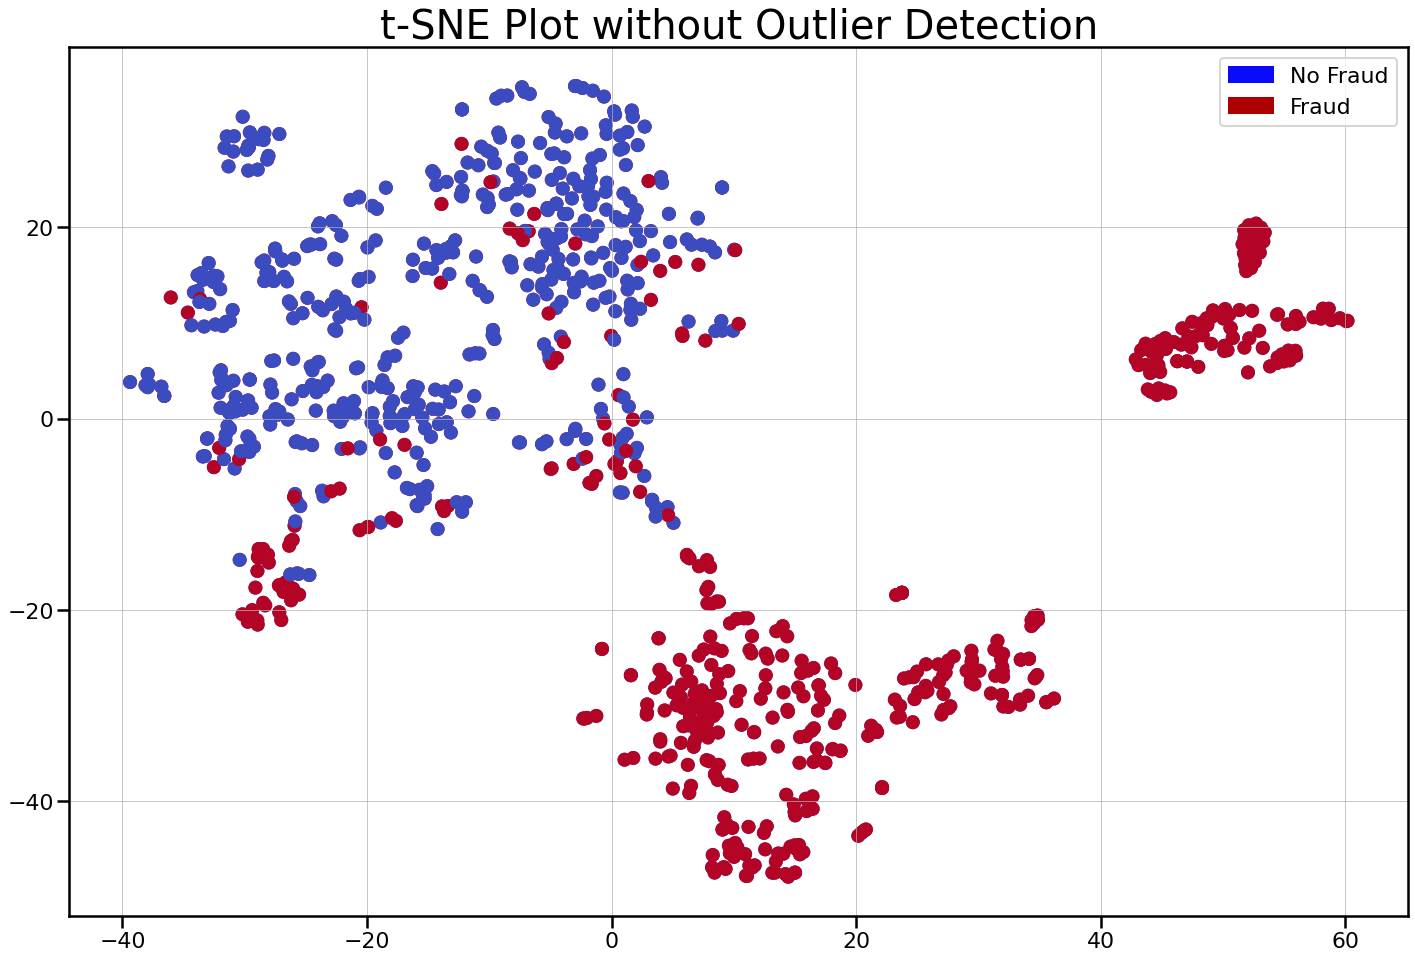

In [31]:
X = ndata.drop('Class', axis=1)
Y = ndata['Class']

#t-SNE
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)

# t-SNE scatter plot
f, ax = plt.subplots(figsize=(24,16))


blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')

ax.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(Y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(Y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax.set_title('t-SNE Plot without Outlier Detection', fontsize=40)

ax.grid(True)

ax.legend(handles=[blue_patch, red_patch])

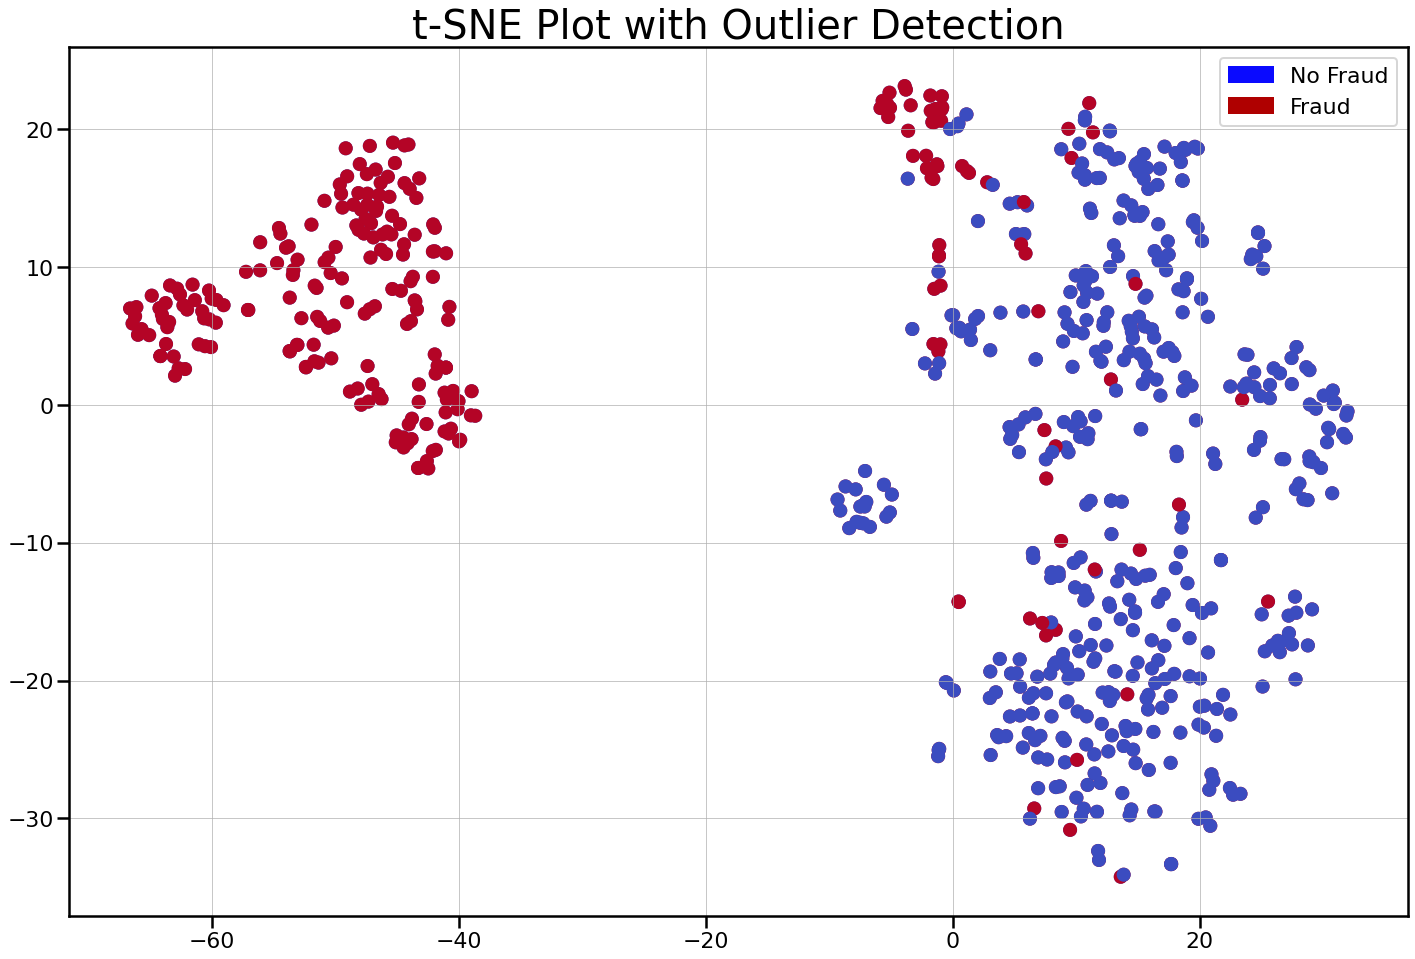

In [32]:
X = df2.drop('Class', axis=1)
Y = df2['Class']

#t-SNE
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)

# t-SNE scatter plot
f, ax = plt.subplots(figsize=(24,16))


blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')

ax.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(Y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(Y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax.set_title('t-SNE Plot with Outlier Detection', fontsize=40)

ax.grid(True)

ax.legend(handles=[blue_patch, red_patch])

# Train Test Split the data

In [23]:
#To handle warning exeptions
def warn(*args, **kwargs):
    pass
warnings.warn = warn

In [24]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=1)

In [25]:
X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

print('X_shapes:\n', 'X_train:', 'X_test:\n', X_train.shape, X_test.shape, '\n')
print('Y_shapes:\n', 'Y_train:', 'Y_test:\n', Y_train.shape, Y_test.shape)

X_shapes:
 X_train: X_test:
 (556, 30) (139, 30) 

Y_shapes:
 Y_train: Y_test:
 (556,) (139,)


In [26]:
##Spot-Checking Algorithms
models = []

models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('SVM', SVC()))
models.append(('XGB', XGBClassifier()))
models.append(('RF', RandomForestClassifier()))

#testing models
results = []
names = []

for name, model in models:
    kfold = KFold(n_splits=10, random_state=42)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='roc_auc')
    results.append(cv_results)
    names.append(name)
    msg = '%s: %f (%f)' % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.967671 (0.035088)
LDA: 0.969044 (0.031792)
KNN: 0.960247 (0.034841)
CART: 0.902623 (0.033578)
SVM: 0.971815 (0.026956)
XGB: 0.967591 (0.028800)
RF: 0.964010 (0.036788)


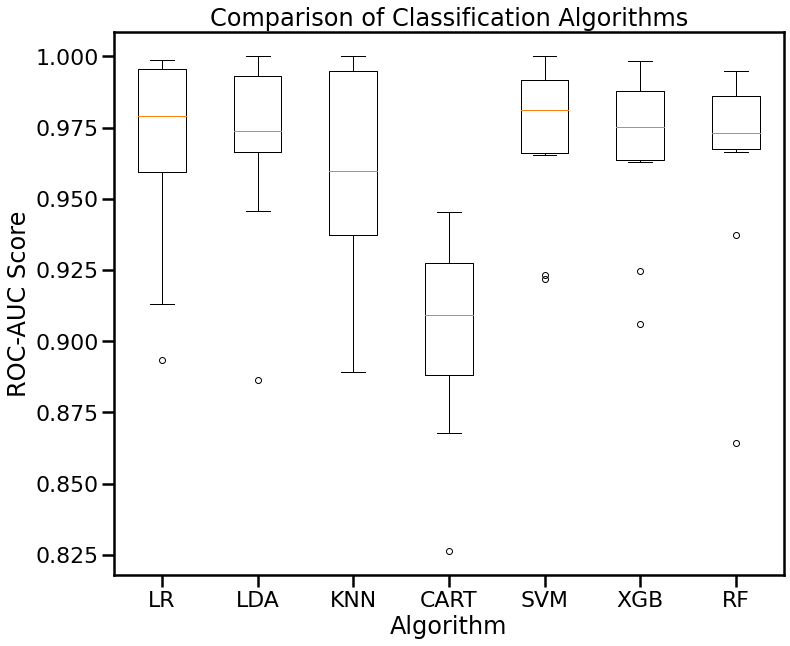

In [27]:
#Compare Algorithms
fig = plt.figure(figsize=(12,10))
plt.title('Comparison of Classification Algorithms')
plt.xlabel('Algorithm')
plt.ylabel('ROC-AUC Score')
plt.boxplot(results)
ax = fig.add_subplot(111)
ax.set_xticklabels(names)
plt.show()

In [30]:
# Visualizing Random Forest
model = RandomForestClassifier(n_estimators=10)

# Train
model.fit(X_train, Y_train)

# Extract single tree
estimator = model.estimators_[5]

# Export as dot file
dot_data = export_graphviz(estimator, out_file='tree.dot', 
                feature_names = X.columns.tolist(),
                class_names = ['0',' 1'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
Image(filename = 'tree.png')